## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Basic
from IPython.display import display

# For OS-agnostic paths
from pathlib import Path

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import numpy as np
sns.set_style("whitegrid")
from copy import deepcopy
import glob, json
from datetime import datetime
import torch
from torch import nn

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import DataLoader, Dataset, TensorDataset


from torchinfo import summary

import mlflow

%cd ..

from src.utils import load_raw_data
from src.plotting import plot_pointcloud, plot_sample_figures
from src.models.HardSphereGAN import GAN
from src.models.StaticScaler import StaticMinMaxScaler

%cd -

plt.set_cmap("viridis")

/Users/veikko/Documents/GitHub/hard-spheres
/Users/veikko/Documents/GitHub/hard-spheres/Notebooks


<Figure size 640x480 with 0 Axes>

# Hard spheres model development


First stage: Develop a CNN - based GAN to work with ordered point clouds.'

This notebook is an attempt at the simpler hexagonal and square lattices after slow progress in the full-scale experiment.

In [4]:

phis = [0.84] # Add more phis here

path = Path("../data/raw/crystal/Sq")
path = Path("../data/raw/crystal/Hex")


files, dataframe, metadata = load_raw_data(path, phi=phis, subpath="disorder-0.2")
# files, dataframe, metadata = load_raw_data(path, phi=phis)

dataframe.sort_index()

Number of Files found :  100


class         x         y    r
experiment   sample                                   
disorder-0.2 sample-1       1 -0.030240  0.007020  0.5
             sample-1       1  1.089908  0.022341  0.5
             sample-1       1  2.011473 -0.067134  0.5
             sample-1       1  3.027153 -0.018990  0.5
             sample-1       1  4.095725  0.056676  0.5
...                       ...       ...       ...  ...
             sample-99      1 -4.726653 -0.985856  0.5
             sample-99      1 -3.641006 -0.998901  0.5
             sample-99      1 -2.697516 -0.989570  0.5
             sample-99      1 -1.621118 -0.834541  0.5
             sample-99      1 -0.492022 -0.823628  0.5

[160000 rows x 4 columns]

In [70]:
# Hex lattice

N = 1600 
X_box = 41.076212368516387
Y_box = 35.573043402379753   
 
# # Square lattice
# N = 1600
# X_box = 38.225722823651111
# y_box = 38.225722823651111 
# dataframe["r"] = 0.375 # Fixed radius for all data, for square lattice

In [71]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StaticMinMaxScaler(
    columns = ["x", "y", "r"],
    maximum = [X_box, Y_box, 2*X_box], # NOTE: Tuned for physical feasibility
    minimum = [-X_box, -Y_box, 0] # NOTE: Tuned for physical feasibility
)

dataframe_scaled = pd.DataFrame(scaler.transform(dataframe), columns=dataframe.columns)

dataframe_scaled.set_index(dataframe.index, inplace=True)

dataframe_scaled = dataframe_scaled.drop(columns=["class"]) # Redundant with r
dataframe_scaled = dataframe_scaled.sort_values(by=["experiment", "sample"])
dataframe_scaled.describe().round(7)

,x,y,r
count,160000.000000,160000.000000,160000.000000
mean,0.500041,0.500069,0.004905
std,0.146112,0.157006,0.000000
min,0.247042,0.228179,0.004905
25%,0.373534,0.364100,0.004905
50%,0.500025,0.500002,0.004905
75%,0.626463,0.635903,0.004905
max,0.752958,0.771821,0.004905


# Plot an example

torch.Size([1, 1600, 3])


<Axes: >

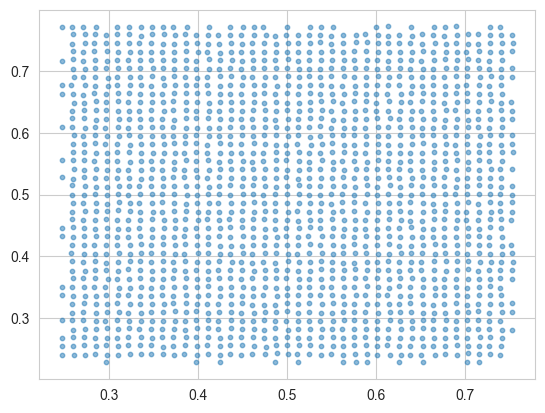

In [72]:
sample = dataframe_scaled.copy().query("(sample=='sample-1')").loc[:,["x", "y", "r"]].reset_index(drop=True)
sample = torch.tensor(sample.values).unsqueeze(0)
print(sample.shape)
plot_pointcloud(sample[0], plot_radius=False)

## Build dataset

Creating Dataset
Descriptor List:  ['phi']
torch.Size([100, 1, 1])
torch.Size([100, 1600, 3])


<Axes: >

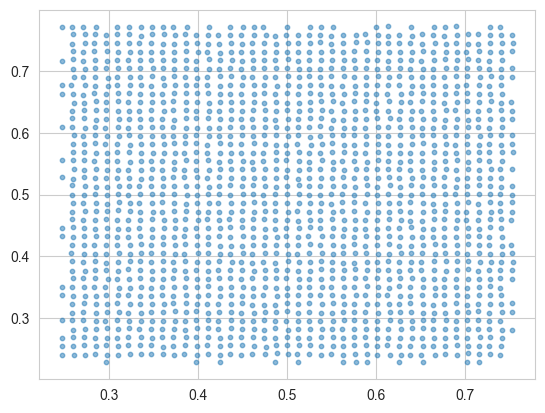

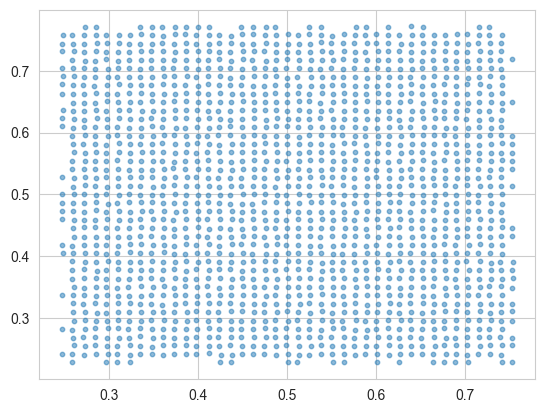

In [73]:
## Build dataset
from src.HSDataset import HSDataset

dataset = HSDataset(
    dataframe_scaled.copy(), # Dont use the ordering
    descriptor_list=["phi"],
    synthetic_samples={"rotational": 0, "shuffling": 0, "spatial_offset_static": 0, "spatial_offset_repeats": 0}, 
    downsample=0
    )
print(dataset[:][0].shape)
print(dataset[:][1].shape)

# Create a function that visualizes the point cloud
plot_pointcloud(dataset[0][1], plot_radius=False)
plot_pointcloud(dataset[-1][1], plot_radius=False)

Text(0.5, 1.0, 'Mean Point Cloud')

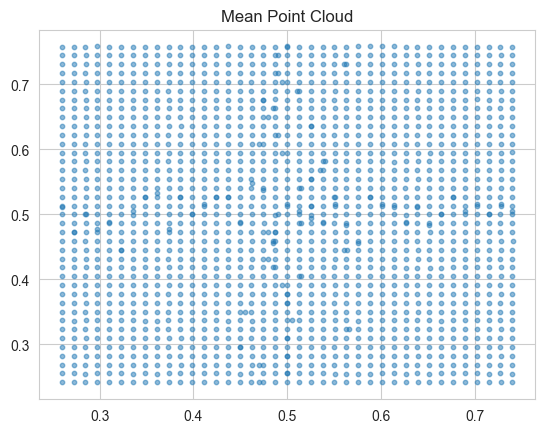

In [74]:
plot_pointcloud(dataset[:][1][:,:,:].mean(dim=0), plot_radius=False)

plt.title("Mean Point Cloud")

# Create model

Create a GAN architecture, which creates point clouds $\hat{y}$ based on the descriptor(s) $\hat{X}$ and a random noise vector $\hat{z}$.

In [75]:
sample_x = dataset[0:32][0].cpu()#.transpose(-1,-2)
sample_y = dataset[0:32][1].cpu()

sample_x_mps = sample_x.to("mps")
sample_y_mps = sample_y.to("mps")

print(sample_x.shape, sample_y.shape)


torch.Size([32, 1, 1]) torch.Size([32, 1600, 3])


In [76]:
# Make a generator model as described in the paper
# paper: https://arxiv.org/pdf/2404.06734

in_features = 64
kernel_size = (3,3) # if 3x3, the output x,y,r will correlate with each other
stride = (1,1)

from src.models.CryinGAN import Generator, CCCGenerator

out_samples = dataset.samples[0].shape[1]

generator_model_2 = CCCGenerator(kernel_size=1, stride=1,
    rand_features=64, out_dimensions=2, fix_r=0.5, out_samples=out_samples).to("mps")

print(sample_x.shape)
_out = generator_model_2(sample_x).detach().cpu()
print(_out.shape)

print(summary(generator_model_2, input_data=sample_x, depth=2))

torch.Size([32, 1, 1])
torch.Size([32, 1600, 2])
Layer (type:depth-idx)                   Output Shape              Param #
CCCGenerator                             [32, 1600, 2]             --
├─Sequential: 1-1                        [32, 1600, 2]             --
│    └─Linear: 2-1                       [32, 9600]                624,000
│    └─ReLU: 2-2                         [32, 9600]                --
│    └─Unflatten: 2-3                    [32, 6, 1600, 1]          --
│    └─ConvTranspose2d: 2-4              [32, 128, 1600, 2]        1,664
│    └─BatchNorm2d: 2-5                  [32, 128, 1600, 2]        256
│    └─ReLU: 2-6                         [32, 128, 1600, 2]        --
│    └─ConvTranspose2d: 2-7              [32, 64, 1600, 2]         8,256
│    └─BatchNorm2d: 2-8                  [32, 64, 1600, 2]         128
│    └─ReLU: 2-9                         [32, 64, 1600, 2]         --
│    └─ConvTranspose2d: 2-10             [32, 32, 1600, 2]         2,080
│    └─BatchNorm2d: 

## Train the model

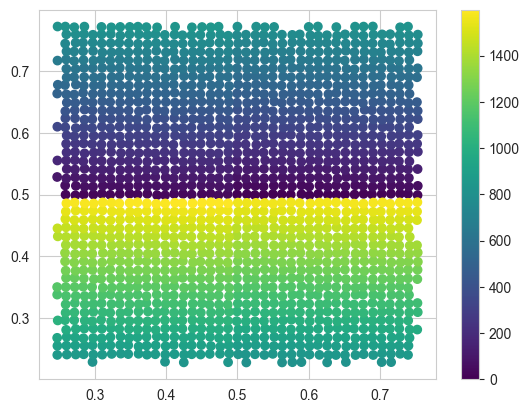

In [77]:
plt.scatter(sample_y[0][:,0].cpu(), sample_y[0][:,1].cpu(), c=list(range(len(sample_y[0][:,0]))), cmap="viridis")
plt.colorbar()

Creating Dataset
Descriptor List:  ['phi']
torch.Size([32, 1, 1]) torch.Size([32, 800, 2])
torch.Size([800, 800, 2])


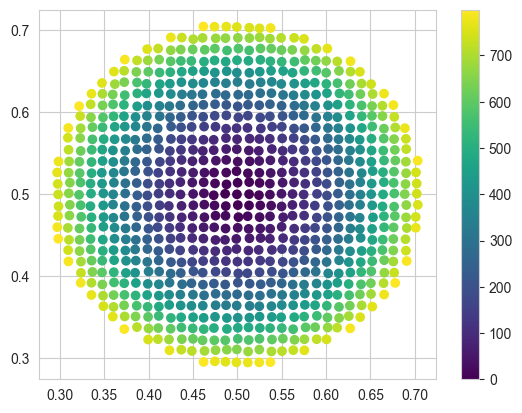

In [78]:
max_out_samples = N # Max size
downsample = 0.5
fix_r = 0.0049

if downsample:
    out_samples = int(max_out_samples * downsample)
else:
    out_samples = max_out_samples
kernel_size = (1,1)
stride = 1

run_params = {
    "comment": "CCCGenerator",
    "training":{
        "device": "mps" if torch.backends.mps.is_available() else "cpu", # MPS is not supported by PyTorch 2D TransposeConv
        "batch_size": 32,
        "epochs": 5000,
        "early_stopping_patience": 20,
        "early_stopping_headstart": 0,
        "early_stopping_tolerance": 1e-3, # Gradient norm based
        "log_image_frequency": 3,
        "generator_headstart": 0,
        "training_ratio_dg": 3,
        "optimizer_g": {
            "name": "Adam",
            "lr": 0.001, # 0.00005, #0.002, 
            # "hypergrad_lr": 1e-6,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "optimizer_d": {
            "name": "Adam",
            "lr": 0.001, #0.002, 
            # "hypergrad_lr": 1e-6,
            "weight_decay": 0,
            "betas": (0.5, 0.999)
        },
        "d_loss":{
            "name": "CryinGANDiscriminatorLoss", # CryinGANDiscriminatorLoss for WaGAN + L1 loss, BCELoss for baseline
            "mu": 1.0, # L1 loss coefficient
        },
        "g_loss":{
            "name": "HSGeneratorLoss",
            "radius_loss": 0,
            "grid_density_loss": 1,
            "gan_loss": 1,
            "distance_loss": 1,
            "physical_feasibility_loss": 0,
            "coefficients":{
                "gan_loss": 1,
                "radius_loss": 0,
                "grid_density_loss": 100,
                "physical_feasibility_loss": 0,
                "distance_loss": 100,
            },
        }
    },
    "dataset":{
        "descriptor_list": ["phi"],
        "synthetic_samples":{
            "rotational": 1,
            "shuffling": 0,
            "spatial_offset_static": 0.05,
            "spatial_offset_repeats": 2
            }, # NOTE: Could do subsquares and more rotations.
        "downsample": downsample,
        "keep_r": False
    },
    "generator": {
        "class": "CCCGenerator",
        "kernel_size": kernel_size,
        "stride": stride,
        "channels_coefficient": 1,
        "rand_features": 512,# 513 for one paper, 64 for another,
        "out_dimensions": 2,
        "out_samples": out_samples,
        "latent_dim": 128, # 128 for the papers
        "fix_r": fix_r,
        "clip_output": False
    },
    "discriminator": {
        "class": "CCCGDiscriminator",
        "input_channels": 2, 
        "in_samples": out_samples, 
        "kernel_size": (1,1),
        "channels_coefficient": 3
    },
    "metrics":{
        "packing_fraction": True,
        "packing_fraction_fix_r": fix_r,
        "packing_fraction_box_size": 1,
    }
}

dataset = HSDataset(
    dataframe_scaled.copy(), # Dont use the ordering
    **run_params["dataset"]
    )

sample_x = dataset[0:32][0].cpu()#.transpose(-1,-2)
sample_y = dataset[0:32][1].cpu()

sample_x_mps = sample_x.to("mps")
sample_y_mps = sample_y.to("mps")

print(sample_x.shape, sample_y.shape)
print(dataset.y.shape)
plt.scatter(sample_y[0][:,0].cpu(), sample_y[0][:,1].cpu(), c=list(range(len(sample_y[0]))), cmap="viridis")
plt.colorbar()


torch.Size([32, 1, 1]) torch.Size([32, 800, 2])
Layer (type:depth-idx)                   Output Shape              Param #
CCCGenerator                             [32, 800, 2]              --
├─Sequential: 1-1                        [32, 800, 2]              --
│    └─Linear: 2-1                       [32, 102400]              52,531,200
│    └─ReLU: 2-2                         [32, 102400]              --
│    └─Unflatten: 2-3                    [32, 128, 800, 1]         --
│    └─ConvTranspose2d: 2-4              [32, 128, 800, 2]         32,896
│    └─BatchNorm2d: 2-5                  [32, 128, 800, 2]         256
│    └─ReLU: 2-6                         [32, 128, 800, 2]         --
│    └─ConvTranspose2d: 2-7              [32, 64, 800, 2]          8,256
│    └─BatchNorm2d: 2-8                  [32, 64, 800, 2]          128
│    └─ReLU: 2-9                         [32, 64, 800, 2]          --
│    └─ConvTranspose2d: 2-10             [32, 32, 800, 2]          2,080
│    └─BatchNorm2

10603201

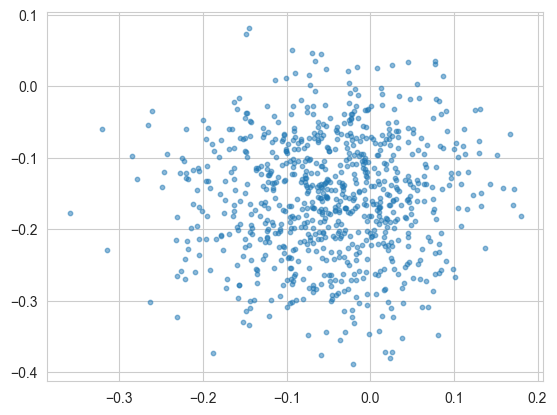

In [79]:
test_frac = 0.2

dataset = dataset.to(run_params["training"]["device"])
trainset, testset = torch.utils.data.random_split(dataset, [1-test_frac, test_frac])

sample_x = dataset[0:32][0].cpu()#.transpose(-1,-2)
sample_y = dataset[0:32][1].cpu()

sample_x_mps = sample_x.to("mps")
sample_y_mps = sample_y.to("mps")

print(sample_x.shape, sample_y.shape)

gan = GAN(
    dataset, 
    dataset,# No separate test set
    **run_params
    )

print(summary(gan.generator, input_data=sample_x_mps, depth=2))
print(summary(gan.discriminator, input_data=sample_y_mps, depth=2))

_out = gan.generate(sample_x)[0]

plot_pointcloud(_out, plot_radius=False)
# plt.xlim(0,1)
# plt.ylim(0,1)
10_603_201

Run the training

In [80]:
sample_size = out_samples

gan.train_n_epochs(
    epochs=run_params["training"]["epochs"],
    batch_size=run_params["training"]["batch_size"],
    experiment_name=f"Square lattice, sample size = {sample_size}",
    requirements_file = Path("../top-level-requirements.txt"),
    save_model=True
)

2025/01/22 23:05:10 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2025/01/22 23:05:10 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Using requirements file: /Users/veikko/Documents/GitHub/hard-spheres/top-level-requirements.txt
Starting run river-cloud-b9215e22-0f02-47f8-9812-13a488b5046b...
Time: 2025-01-22 23:05:10


  0%|          | 4/5000 [01:13<25:27:10, 18.34s/it]


Interrupted
Logging models to mlflow


2025/01/22 23:06:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run river-cloud-b9215e22-0f02-47f8-9812-13a488b5046b at: http://127.0.0.1:8080/#/experiments/497729340261771256/runs/48e5d51ad6c74168b8ec585ce4134bd9.
2025/01/22 23:06:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/497729340261771256.
2025/01/22 23:06:25 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/01/22 23:06:25 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [321]:
import mlflow
logged_model = 'runs:/94662023d37747e89a6e769bd9d8aa63/discriminator'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd

data = (dataframe_scaled.query("sample=='sample-1'").loc[:,["x", "y", "r"]].values[::20].reshape(1, 80, 3))
data = data.astype(np.float32)
print(data.shape)

loaded_model.predict(data)

(1, 80, 3)


array([[0.90115356]], dtype=float32)

In [ ]:
# NOTE: Alternative generator with diffusion
# generator = CCCGeneratorWithDiffusion(
#     kernel_size=kernel_size,
#     channels_coefficient=1,
#     stride=stride,
#     rand_features=513,
#     out_dimensions=out_dimensions,
#     out_samples=out_samples,
#     latent_dim=256, # initial latent channels
#     fix_r=0.0049,
#     clip_output = False
#     # (
#     #     dataset.y.min(dim=0).values.min(dim=0).values,
#     #     dataset.y.max(dim=0).values.max(dim=0).values
#     #     )
#     ).to("mps")

## Test the discriminator with random data

torch.Size([32, 40, 3])
torch.Size([32, 1])
Mean of discriminator output: 0.5999366044998169


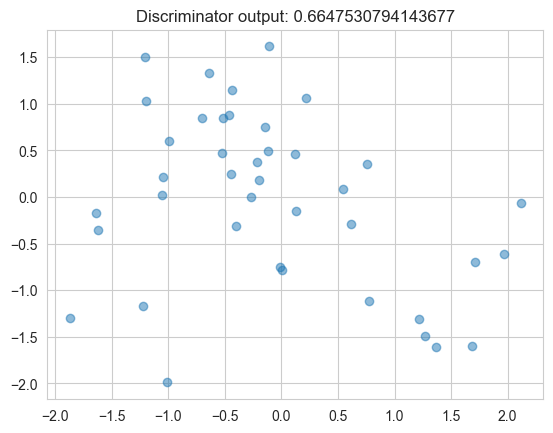

In [91]:
# Test the discriminator with random data

# Generate random data
random_data = torch.rand_like(sample_y).to("mps")
random_data = torch.randn_like(sample_y).to("mps")
print(random_data.shape)

plot_pointcloud(random_data[0].cpu().numpy(), plot_radius=False)

# Test the discriminator

output = gan.discriminator(random_data)
print(output.shape)
print("Mean of discriminator output:", output.mean().item())
plt.title(f"Discriminator output: {output[0].item()}")
plt.show()

## Visualize the weights on the first layer

In [110]:
first_layer_weights.shape

(10240, 64)

In [241]:
first_layer_weights.shape

(20480, 513)

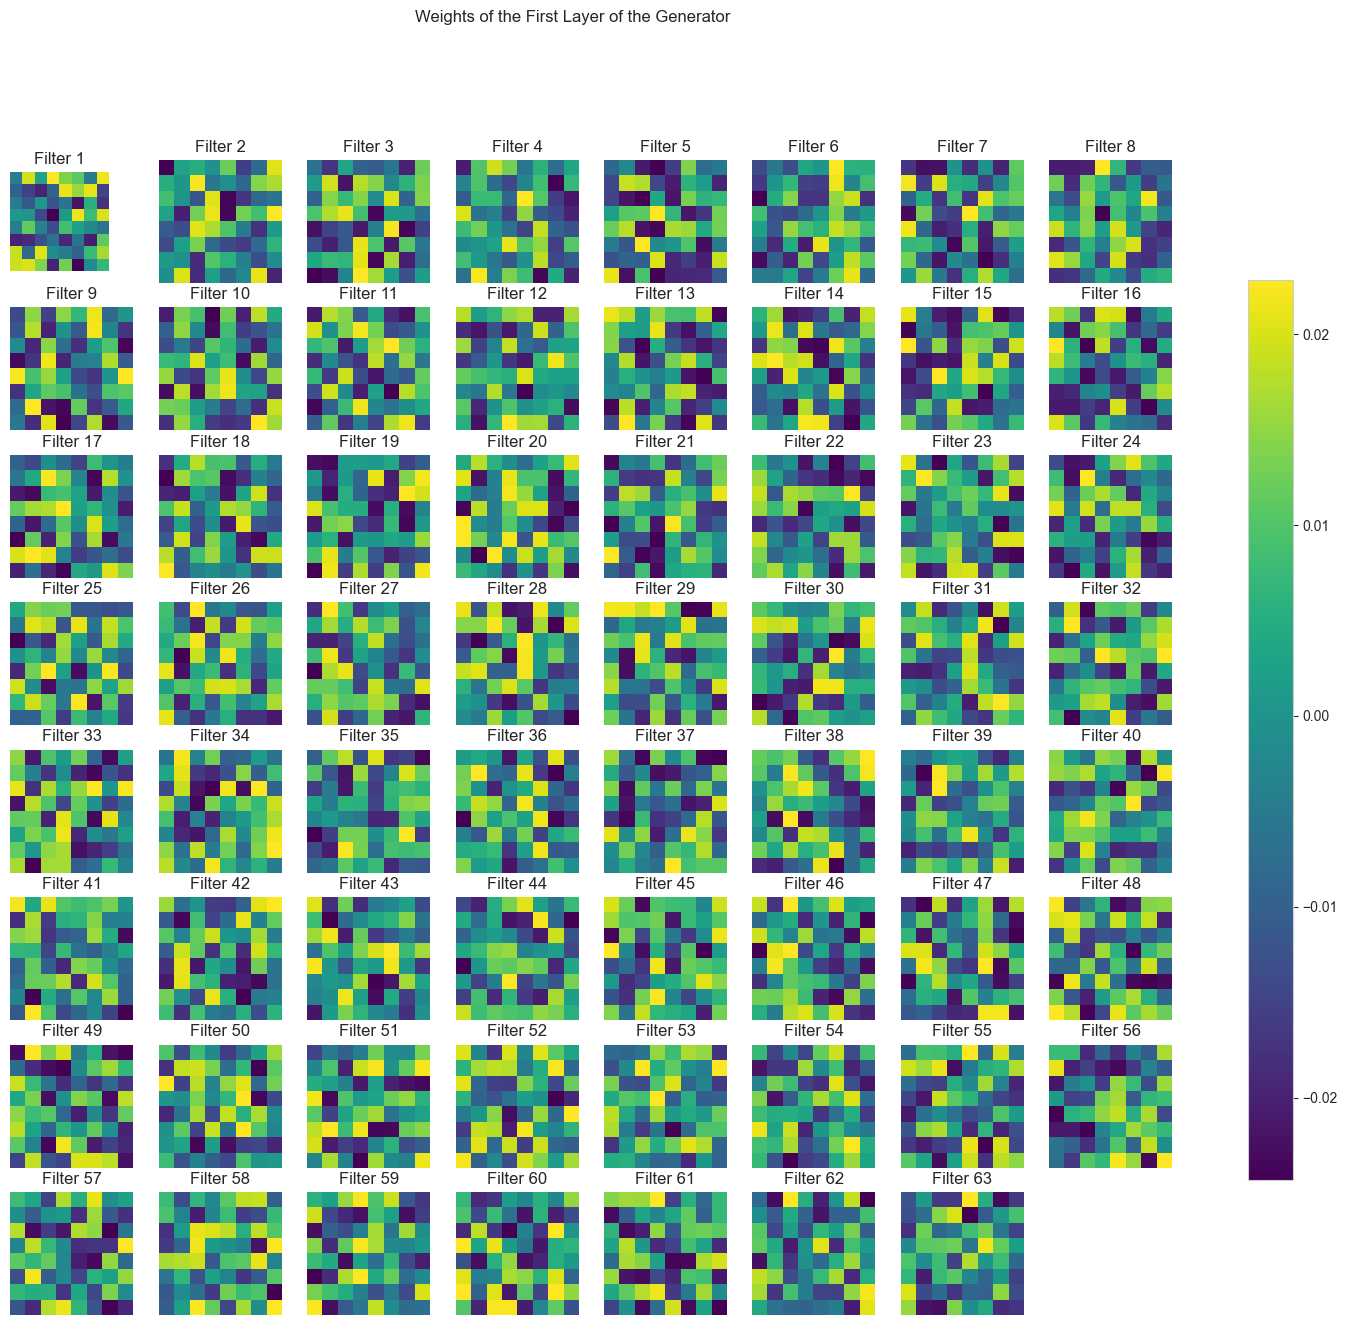

In [242]:
# Extract the weights from the first layer of the generator
first_layer_weights = gan.generator.model[0].weight.data.cpu().numpy()

max_filters = 64
first_layer_weights = first_layer_weights[:, :max_filters]

# Plot the weights
plt.figure(figsize=(15, 15))
for i in range(1,first_layer_weights.shape[1]):
    plt.subplot(8, 8, i)
    plt.imshow(first_layer_weights[i].reshape(8, 8), cmap='viridis')
    plt.axis('off')
    # Add a global colorbar
    if i == 1:
        plt.colorbar()
        # Relocate the colorbar
        plt.gcf().axes[-1].set_position([0.95, 0.1, 0.03, 0.8])

    plt.title(f'Filter {i}')

plt.suptitle('Weights of the First Layer of the Generator')
plt.show()

In [122]:
first_layer_weights.shape

(10, 256)

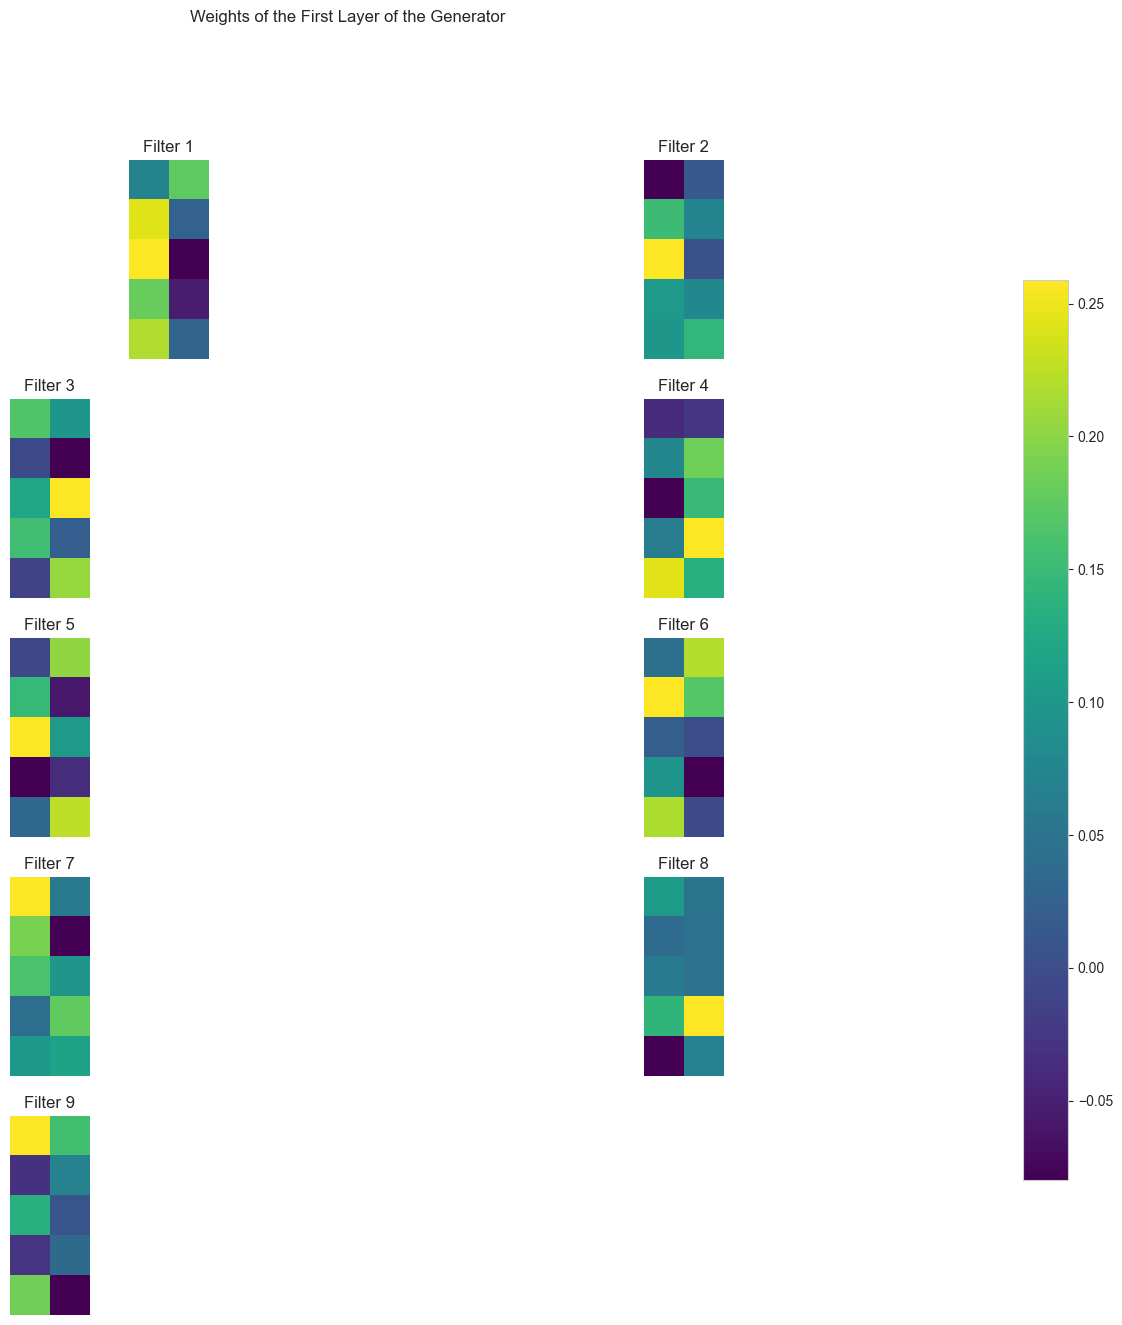

In [127]:
# Extract the weights from the first layer of the generator
first_layer_weights = gan.discriminator.fc_layers[-3].weight.data.cpu().numpy()

# Plot the weights
plt.figure(figsize=(15, 15))
for i in range(1,first_layer_weights.shape[0]):
    plt.subplot(5, 2, i)
    plt.imshow(first_layer_weights[:,i].reshape(5, 2), cmap='viridis')
    plt.axis('off')
    # Add a global colorbar
    if i == 1:
        plt.colorbar()
        # Relocate the colorbar
        plt.gcf().axes[-1].set_position([0.95, 0.1, 0.03, 0.8])

    plt.title(f'Filter {i}')

plt.suptitle('Weights of the First Layer of the Generator')
plt.show()

## 